In [296]:
import pandas as pd
%matplotlib inline

stats = pd.read_json('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json')

footer = f'Source https://github.com/pcm-dpc/COVID-19 - Last Updated {stats["data"].tolist()[-1]}'

# format and sort by date
stats['data'] = stats['data'].transform(lambda s: s[:10])stats.sort_values(by=['data'], inplace=True)
stats['data'] = pd.to_datetime(stats['data'])
stats['data'] = stats['data'].dt.strftime('%d %b')

measures = {
            'deceduti': 'Deaths',
            'terapia_intensiva': 'Intensive Care',
            'dimessi_guariti': 'Recovered',
            'totale_casi': 'Total Cases'
           }

sub_measures = {
                'delta': { 'color': 'plum', 'label': 'First Derivative', 'is_percentage': False },
                'delta_2': { 'color': 'sandybrown', 'label': 'Second Derivative', 'is_percentage': False },
                'delta_3': { 'color': 'yellowgreen', 'label': 'Third Derivative', 'is_percentage': False }
               }

for measure in measures:
    stats[f'{measure}_delta'] = stats[measure].diff()
    stats[f'{measure}_delta_2'] = stats[f'{measure}_delta'].diff()
    stats[f'{measure}_delta_3'] = stats[f'{measure}_delta_2'].diff()

stats.dropna(inplace=True)

stats.tail(3)

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,...,deceduti_delta_3,terapia_intensiva_delta,terapia_intensiva_delta_2,terapia_intensiva_delta_3,dimessi_guariti_delta,dimessi_guariti_delta_2,dimessi_guariti_delta_3,totale_casi_delta,totale_casi_delta_2,totale_casi_delta_3
21,16 Mar,ITA,11025,1851,12876,10197,23073,2470,2749,2158,...,-212.0,179.0,25.0,61.0,414.0,45.0,203.0,3233.0,-357.0,-450.0
22,17 Mar,ITA,12894,2060,14954,11108,26062,2989,2941,2503,...,15.0,209.0,30.0,5.0,192.0,-222.0,-267.0,3526.0,293.0,650.0
23,18 Mar,ITA,14363,2257,16620,12090,28710,2648,4025,2978,...,134.0,197.0,-12.0,-42.0,1084.0,892.0,1114.0,4207.0,681.0,388.0


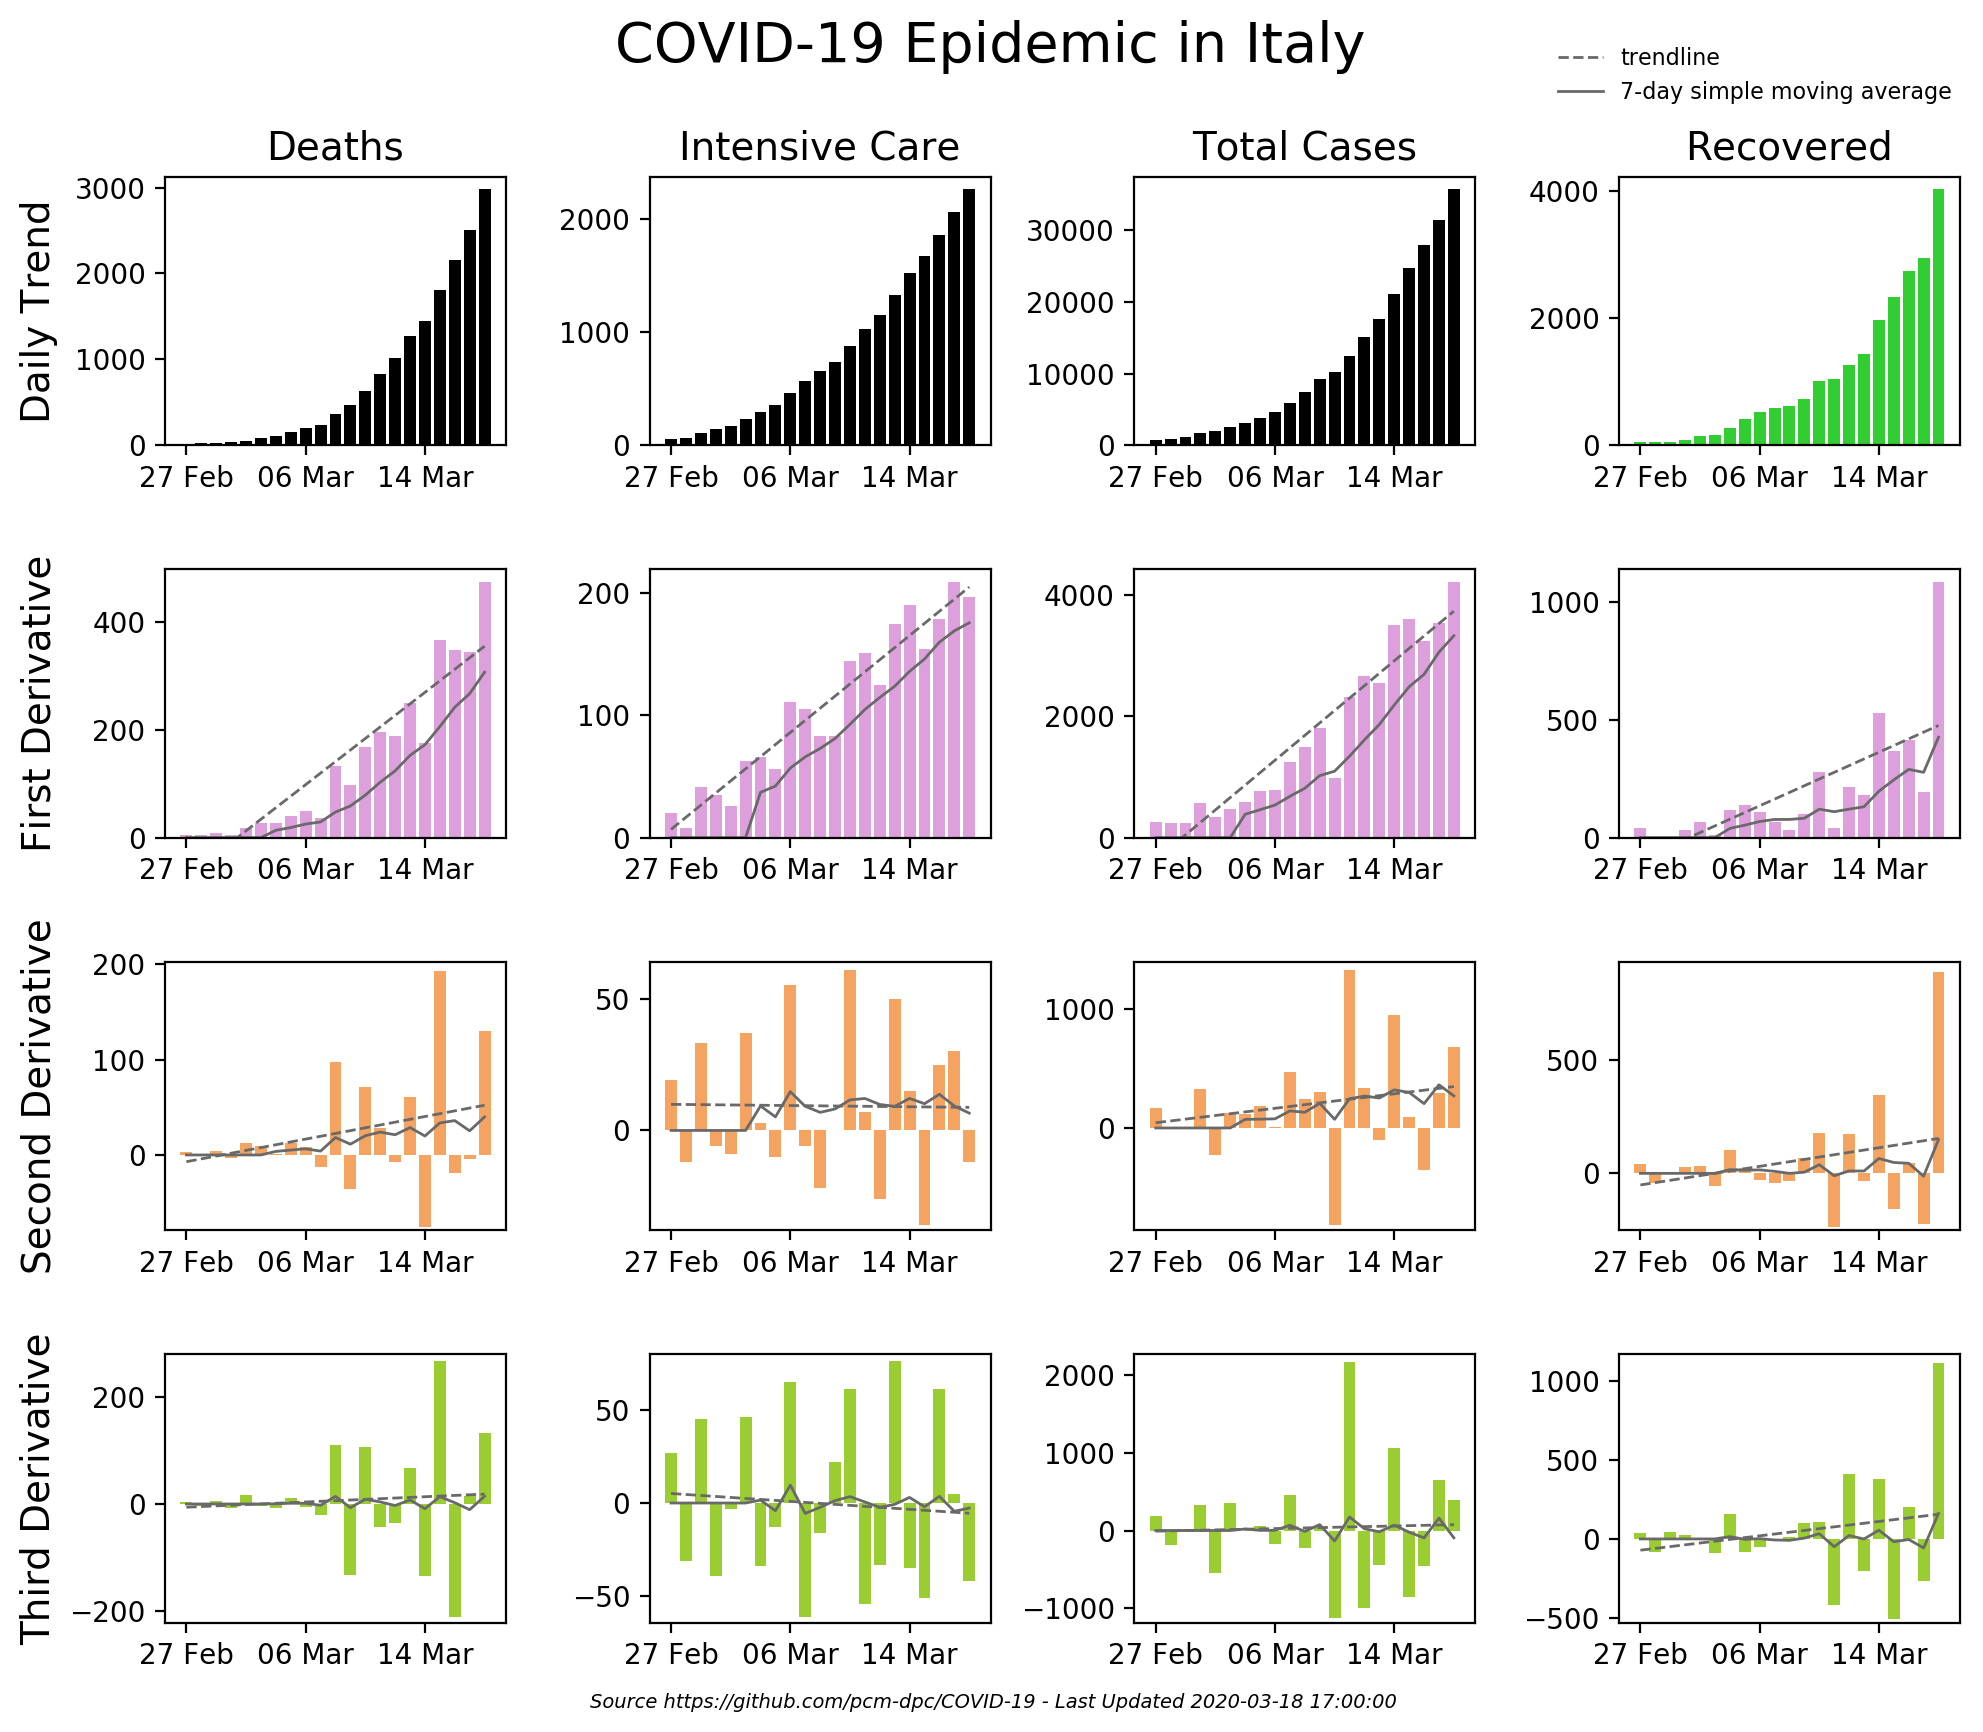

In [310]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

legend_lines = [Line2D([0], [0], color='dimgray', lw=1, ls='--'),
                Line2D([0], [0], color='dimgray', lw=1, ls='-')]
legend_labels = ('trendline', f'{moving_avg_days}-day simple moving average')

moving_avg_days = 7

def plot(ax, measure, display_y_labels=False, main_color='black'):
    x = stats['data']
    y = stats[measure]

    ax[0].bar(x, y, color=main_color)
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(3))
    ax[0].set_title(measures[measure], fontsize=14)
    
    if display_y_labels:
        ax[0].set_ylabel('Daily Trend', fontsize=14)

    for i, sub_measure in enumerate(sub_measures):
        color = sub_measures[sub_measure]['color']
        label = sub_measures[sub_measure]['label']

        if display_y_labels:
            ax[i+1].set_ylabel(label, fontsize=14)

        y_sub = stats[f'{measure}_{sub_measure}']
        ax[i+1].bar(x, y_sub, color=color, lw=1)

        # trendline
        z = np.polyfit(range(len(x)), y_sub, 1)
        p = np.poly1d(z)
        ax[i+1].plot(range(len(x)), p(range(len(x))), color='dimgray', lw=legend_lines[0].get_linewidth(), ls=legend_lines[0].get_linestyle())
        
        # n-day simple moving average
        rolling = y_sub.rolling(window=moving_avg_days).mean().fillna(value=0)
        ax[i+1].plot(range(len(x)), rolling, color='dimgray', lw=legend_lines[1].get_linewidth(), ls=legend_lines[1].get_linestyle())

        # limit number of x ticks
        ax[i+1].xaxis.set_major_locator(plt.MaxNLocator(3))

        # set range for y axes
        ax[i+1].set_ylim((min(0, y_sub.min()*1.05), y_sub.max()*1.05))
        
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 8), dpi=200)

plot(axes[:, 0], 'deceduti', True)
plot(axes[:, 1], 'terapia_intensiva')
plot(axes[:, 2], 'totale_casi')
plot(axes[:, 3], 'dimessi_guariti', False, 'limegreen')

plt.tight_layout()

# legend, title and footer
fig.legend(legend_lines, legend_labels, loc=(0.781, 0.935), fontsize=8, frameon=False)
fig.suptitle('COVID-19 Epidemic in Italy', y=1.05, fontsize=20)
fig.text(0.3, -0.005, footer, fontsize=7, style='italic')
fig.align_ylabels()

plt.show()